# Recommender Systems


# Preprocessing

First, let's get all of the imports out of the way:


In [2]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from sklearn.neighbors import  NearestNeighbors
import heapq
# Modelling
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering, KNNWithMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Packages for Randomisation
import random


# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

#extra 
from itertools import permutations
import heapq
import pickle

#Math functions, we'll only need the sqrt function so let's import only that
from math import sqrt


Now let's read each file into their Dataframes:


In [3]:
ratings_df = pd.read_csv("../resources/data/ratings.csv")
movies_df = pd.read_csv("../resources/data/movies.csv")
train = pd.read_csv("../resources/data/train.csv")
test = pd.read_csv("../resources/data/test.csv")

Let's also remove the year from the **title** column by using pandas' replace function and store in a new **year** column.


In [4]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


With that, let's also split the values in the **Genres** column into a **list of Genres** to simplify for future use. This can be achieved by applying Python's split string function on the correct column.


In [5]:
#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Since keeping genres in a list format isn't optimal for the content-based recommendation system technique, we will use the One Hot Encoding technique to convert the list of genres to a vector where each column corresponds to one possible value of the feature. This encoding is needed for feeding categorical data. In this case, we store every different genre in columns that contain either 1 or 0. 1 shows that a movie has that genre and 0 shows that it doesn't. Let's also store this dataframe in another variable since genres won't be important for our first recommendation system.


In [6]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres_df = movies_df.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's look at the ratings dataframe.


In [7]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Every row in the ratings dataframe has a user id associated with at least one movie, a rating and a timestamp showing when they reviewed it. We won't be needing the timestamp column, so let's drop it to save memory.


In [8]:
#Drop removes a specified row or column from a dataframe
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


# Dimensionality reduction
Most machine learning algorithms tend to perform poorly as the number of dimensions in the data increases. This phenomenon is often known as the curse of dimensionality. Therefore, it is a good idea to reduce the number of features available in the data, while retaining the maximum amount of information possible. There are two ways to achieve this:

- *Feature selection*: This method involves identifying the features that have the least predictive power and dropping them altogether. Therefore, feature selection involves identifying a subset of features that is most important for that particular use case. An important distinction of feature selection is that it maintains the original meaning of every retained feature. For example, let's say we have a housing dataset with price, area, and number of rooms as features. Now, if we were to drop the area feature, the remaining price and number of rooms features will still mean what they did originally.
- *Feature selection*: This method involves identifying the features that have the least predictive power and dropping them altogether. Therefore, feature selection involves identifying a subset of features that is most important for that particular use case. An important distinction of feature selection is that it maintains the original meaning of every retained feature. For example, let's say we have a housing dataset with price, area, and number of rooms as features. Now, if we were to drop the area feature, the remaining price and number of rooms features will still mean what they did originally.

we will take a look at an important feature-extraction method: Principal component analysis (or PCA).

## Principal component analysis

*Principal component* analysis is an unsupervised feature extraction algorithm that takes in m-dimensional input to create a set of n (m >> n) linearly uncorrelated variables (called principal components) in such a way that the n dimensions lose as little variance (or information) as possible due to the loss of the (m-n) dimensions.

The linear transformation in PCA is done in such a way that the first principal component holds the maximum variance (or information). It does so by considering those variables that are highly correlated to each other. Every principal component has more variance than every succeeding component and is orthogonal to the preceding component.

Consider a three-dimensional space where two features are highly correlated to each other and relatively uncorrelated to the third:

![PCA](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781788993753/files/assets/9f8c85c1-cbc2-44e8-8b2a-9c4a34fcd4e0.png)

Let's say that we want to convert this into a two-dimensional space. To do this, PCA tries to identify the first principal component, which will hold the maximum possible variance. It does so by defining a new dimension using the two highly correlated variables. Now, it tries to define the next dimension in such a way that it holds the maximum variance, is orthogonal to the first principal component constructed, and also is uncorrelated to it. The two new dimensions (or principal components), PC 1 and PC 2, are shown in the preceding figure.


In [9]:
# Scaling the movies_df
# declare the features to be all columns from our movies_df
features = [col for col in ratings_df.columns]

# create scaler object
scaler = StandardScaler()

# define scaled data frame variable
scaled_df = pd.read_csv("../resources/data/ratings.csv")
scaled_df[features] = preprocessing.scale(scaled_df[features])

Text(0, 0.5, 'Cumulative explained variance')

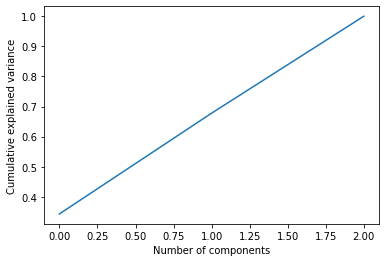

In [10]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(scaled_df[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)



# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [11]:
pca_85 = PCA(.85)
pca_85.fit_transform(scaled_df[features])
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")


100.0 % of variance explained by 3 components.


In [12]:
pca.explained_variance_ratio_[:3]


array([0.34303499, 0.33480581, 0.32215921])

<a id="ref3"></a>

# Content-Based recommendation system

This technique attempts to figure out what a user's favourite aspects of an item is, and then recommends items that present those aspects. In our case, we're going to try to figure out the input's favorite genres from the movies and ratings given.

Let's begin by creating an input user to recommend movies to:

Notice: To add more movies, simply increase the amount of elements in the **userInput**. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .


In [13]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


#### Add movieId to input user

With the input complete, let's extract the input movie's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movie's title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.


In [14]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5
4,164600,Akira,4.5
5,1968,"Breakfast Club, The",5.0


We're going to start by learning the input's preferences, so let's get the subset of movies that the input has watched from the Dataframe containing genres defined with binary values.


In [15]:
#Filtering out the movies from the input
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
292,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1241,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1879,1968,"Breakfast Club, The","[Comedy, Drama]",1985,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42774,164600,Akira,"[Action, Crime, Thriller]",2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We'll only need the actual genre table, so let's clean this up a bit by resetting the index and dropping the movieId, title, genres and year columns.


In [16]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we're ready to start learning the input's preferences!

To do this, we're going to turn each genre into weights. We can do this by using the input's reviews and multiplying them into the input's genre table and then summing up the resulting table by column. This operation is actually a dot product between a matrix and a vector, so we can simply accomplish by calling the Pandas "dot" function.


In [17]:
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
4    4.5
5    5.0
Name: rating, dtype: float64

In [18]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             10.0
Animation              8.0
Children               5.5
Comedy                13.0
Fantasy                5.5
Romance                0.0
Drama                  9.5
Action                 9.5
Crime                 10.0
Thriller              10.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

Now, we have the weights for every of the user's preferences. This is known as the User Profile. Using this, we can recommend movies that satisfy the user's preferences.


Let's start by extracting the genre table from the original dataframe:


In [19]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
genreTable.shape

(62423, 20)

In [21]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.491228
2    0.245614
3    0.152047
4    0.263158
5    0.152047
dtype: float64

In [22]:
#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#Just a peek at the values
recommendationTable_df.head()

movieId
5018      0.730994
64645     0.725146
122787    0.725146
144324    0.725146
81132     0.725146
dtype: float64

Now here's the recommendation table!


In [23]:
#The final recommendation table
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())]

,movieId,title,genres,year
4614,4719,Osmosis Jones,"[Action, Animation, Comedy, Crime, Drama, Roma...",2001
4912,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
8253,8968,After the Sunset,"[Action, Adventure, Comedy, Crime, Thriller]",2004
8638,26184,"Diamond Arm, The (Brilliantovaya ruka)","[Action, Adventure, Comedy, Crime, Thriller]",1968
9177,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
9542,31367,"Chase, The","[Action, Adventure, Comedy, Crime, Romance, Th...",1994
9636,31921,"Seven-Per-Cent Solution, The","[Adventure, Comedy, Crime, Drama, Mystery, Thr...",1976
12879,64645,The Wrecking Crew,"[Action, Adventure, Comedy, Crime, Drama, Thri...",1968
15389,81132,Rubber,"[Action, Adventure, Comedy, Crime, Drama, Film...",2010
17470,91542,Sherlock Holmes: A Game of Shadows,"[Action, Adventure, Comedy, Crime, Mystery, Th...",2011


### Advantages and Disadvantages of Content-Based Filtering

##### Advantages

*   Learns user's preferences
*   Highly personalized for the user

##### Disadvantages

*   Doesn't take into account what others think of the item, so low quality item recommendations might happen
*   Extracting data is not always intuitive
*   Determining what characteristics of the item the user dislikes or likes is not always obvious


# Collaborative Filtering

Now it's time to start our work on recommendation systems.

We're going to take a look at is called **Collaborative Filtering**, which is also known as **User-User Filtering**. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the **Pearson Correlation Function**.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/images/User_Item.png" width=800px>

The process for creating a User Based recommendation system is as follows:

*   Select a user with the movies the user has watched
*   Based on his rating of the movies, find the top X neighbours
*   Get the watched movie record of the user for each neighbour
*   Calculate a similarity score using some formula
*   Recommend the items with the highest score

Let's begin by creating an input user to recommend movies to:

Notice: To add more movies, simply increase the amount of elements in the userInput. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .


In [24]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


#### Add movieId to input user

With the input complete, let's extract the input movies's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movies' title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.


In [25]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,genres,rating
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",3.5
1,2,Jumanji,"[Adventure, Children, Fantasy]",2.0
2,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",5.0
3,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",4.5
4,164600,Akira,"[Action, Crime, Thriller]",4.5
5,1968,"Breakfast Club, The","[Comedy, Drama]",5.0


#### The users who has seen the same movies

Now with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.


In [26]:
#Filtering out users that have watched movies that the input has watched and storing it
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
49,2,296,4.0
100,3,296,4.5
156,4,296,5.0
255,4,1968,5.0
389,5,1968,4.0


We now group up the rows by user ID.


In [27]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = userSubset.groupby(['userId'])

Let's look at one of the users, e.g. the one with userID=11.


In [29]:
userSubsetGroup.get_group(11)

,userId,movieId,rating
794,11,296,5.0


Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.


In [30]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Now let's look at the first user.


In [31]:
userSubsetGroup[0:3]

[(73,
         userId  movieId  rating
  10214      73        1     5.0
  10215      73        2     2.5
  10281      73      296     5.0
  10450      73     1274     4.5
  10557      73     1968     4.5),
 (285,
         userId  movieId  rating
  38828     285        1     4.0
  38829     285        2     3.0
  38870     285      296     4.0
  38982     285     1274     3.0
  39071     285     1968     3.0),
 (561,
         userId  movieId  rating
  82117     561        1     3.0
  82118     561        2     3.0
  82140     561      296     4.5
  82201     561     1274     3.5
  82234     561     1968     4.0)]

#### Similarity of users to input user

Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.\
We're going to find out how similar each user is to the input through the **Pearson Correlation Coefficient**. It is used to measure the strength of a linear association between the two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y, then, pearson(X, Y) == pearson(X, 2 \* Y + 3). This is a pretty important property in recommendation systems because, for example, two users might rate two series of items totally differently in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0 "Pearson Correlation")

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation.

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.


We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.


In [32]:
userSubsetGroup = userSubsetGroup[0:100]

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient.


In [33]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


In [34]:
pearsonCorrelationDict.items()

dict_items([(73, 0.8038925870986305), (285, 0.179028718509858), (561, 0.8272781516947562), (564, 0.537086155529574), (580, 0.8320502943378437), (15, 0.8703882797784892), (19, 0.8553372034476997), (30, 0.899228803025897), (48, 0.592156525463792), (69, 0.17407765595569785), (77, -0.8660254037844387), (119, 0.674199862463242), (134, -0.09090909090909091), (149, 0.9847319278346618), (157, 0.9799578870122228), (177, 0), (185, -0.4629100498862757), (187, 0.9683296637314885), (212, 0.9045340337332909), (262, 0.9506541513652699), (268, 0.8703882797784892), (292, 0.9864400504156211), (306, 0.17407765595569785), (355, 0.8819171036881969), (428, 0.8703882797784892), (442, 0.8181818181818182), (466, 0.09090909090909091), (468, 0.5606119105813882), (472, -0.4082482904638631), (480, -0.9045340337332909), (518, 0.8703882797784892), (607, 0.5720775535473553), (624, 0.30151134457776363), (654, 0.7816608327818948), (47, -0.8660254037844356), (56, 0.5000000000000009), (72, 0.9819805060619667), (78, 0.944

In [35]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.803893,73
1,0.179029,285
2,0.827278,561
3,0.537086,564
4,0.832050,580


#### The top x similar users to input user

Now let's get the top 50 users that are most similar to the input.


### __Item-Item collaborative based filtering__

To tackle the issues with user-based collaborative based techniques, item-based collaborative techniques analyze the user-item matrix and identify relationships between different items. The item-based recommendation system then makes recommendations based on the discovered similarities amongst the items. This method is more stable compared to user based collaborative filtering because the average item has a lot more ratings than the average user. So an individual rating doesn’t impact as much.

The idea of item-item method is to find movies similar to the ones the user already “positively” interacted with. Two items are considered to be similar if most of the users that have interacted with both of them did it in a similar way. This method is said to be “item-centred” as it represents items based on interactions users had with them and evaluates distances between those items.

In [36]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
66,1.0,430
73,1.0,461
51,1.0,232
65,1.0,408
95,1.0,23


Now, let's start recommending movies to the input user.

#### Rating of selected users to all movies

We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our **pearsonDF** from the ratings dataframe and then store their correlation in a new column called \_similarityIndex". This is achieved below by merging of these two tables.


In [37]:
topUsersRating=topUsers.merge(ratings_df, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,430,1,4.0
1,1.0,430,3,1.5
2,1.0,430,6,4.0
3,1.0,430,10,3.5
4,1.0,430,19,2.0


Now all we need to do is simply multiply the movie rating by its weight (the similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:


In [38]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,430,1,4.0,4.0
1,1.0,430,3,1.5,1.5
2,1.0,430,6,4.0,4.0
3,1.0,430,10,3.5,3.5
4,1.0,430,19,2.0,2.0


In [39]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,41.084263,147.632870
2,27.695499,80.495418
3,10.046405,24.498224
4,2.725725,4.936400
5,10.153608,28.084992


In [40]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,3.593417,1
2,2.906444,2
3,2.438506,3
4,1.811041,4
5,2.766011,5


In [41]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
movieId,,
3112,5.0,3112
1846,5.0,1846
6419,5.0,6419
188,5.0,188
2173,5.0,2173
1341,5.0,1341
2483,5.0,2483
8228,5.0,8228
1543,5.0,1543


In [42]:
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,genres,year
186,188,"Prophecy, The","[Fantasy, Horror, Mystery]",1995
1306,1341,Burnt Offerings,[Horror],1976
1488,1543,"Designated Mourner, The",[Drama],1997
1508,1564,For Roseanna (Roseanna's Grave),"[Comedy, Drama, Romance]",1997
1758,1846,Nil By Mouth,[Drama],1997
2083,2173,"Navigator: A Mediaeval Odyssey, The","[Adventure, Fantasy, Sci-Fi]",1988
2392,2483,"Day of the Beast, The (Día de la Bestia, El)","[Adventure, Comedy, Thriller]",1995
3019,3112,'night Mother,[Drama],1986
6297,6419,Mr. & Mrs. Bridge,[Drama],1990
7683,8228,"Maltese Falcon, The (a.k.a. Dangerous Female)",[Mystery],1931


###  __Model based collaborative  filtering__

We will train and evaluate the performance of the models based on a 100k subset of the data. The best performing model will undergo hyperparametere tuning and will be trained on the full dataset for the submission file.

Here, we explored seven models from the surprise package.

In [43]:
# Load the 100k dataset
train.drop('timestamp', axis=1, inplace=True)
train_subset = train[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

Unlike Memory-Based Approaches, Model-Based procedures facilitate machine learning techniques such as Singular Value Decomposition (SVD) and Matrix Factorization models to predict the end user's rating on unrated items. 

We will be using SVD to build our recommender engine. We utilize the results of singular value decomposition (SVD) to fill the vacant ratings and then use the item based method to produce the prediction of unrated items.

Formally, SVD is decomposition of a matrix R which is the utility matrix with m equal to the number of users and m number exposed items (movies) into the product of three matrices:

* U is a left singular orthogonal matrix, representing the relationship between users and latent factors (Hopcroft & Kannan, 2012)

* Σ is a diagonal matrix (with positive real values) describing the strength of each latent factor

* V(transpose) is a right singular orthogonal matrix, indicating the similarity between items and latent factors.

![2020/02/svd2.png](https://www.dataminingapps.com/wp-content/uploads/2020/02/svd2.png)

The general goal of SVD (and other matrix factorization methods) is to decompose the matrix R with all missing values and multiply its components, U, Σ and V once again. As a result, there are no missing values and it is possible to recommend each user movies (items) they have not seen yet.

In [45]:
# svd_sub = SVD()
# svd_sub.fit(trainset)
# svd_pred = svd_sub.test(testset)
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], Reader())
train_set, test_set = train_test_split(data, test_size=0.20)
svd=SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)
svd.fit(train_set)

# Model Preformance

svd = accuracy.rmse(svd_pred)

In [39]:
svdpp_sub = SVDpp()
svdpp_sub.fit(trainset)
svdpp_pred = svdpp_sub.test(testset)

# Model Preformance

svdpp_rmse = accuracy.rmse(svdpp_pred)

RMSE: 0.9792


#### __BaselineOnly__

BaselineOnly algorithm predicts the baseline estimate for given user and item.

A baseline is calculated with Stochastic Gradient Descent (SGD) or ALternating Least Squares (ALS)

In [40]:
bsl_options = {'method':'sgd', 'n_epochs':40}

blo_sub = BaselineOnly(bsl_options=bsl_options)
blo_sub.fit(trainset)
blo_pred = blo_sub.test(testset)

# Model Performance

blo_rmse = accuracy.rmse(blo_pred)

Estimating biases using sgd...
RMSE: 0.9735


#### __Non-negative Matrix Factorization (NMF)__

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization.

In [41]:
nmf_sub = NMF()
nmf_sub.fit(trainset)
nmf_pred = nmf_sub.test(testset)

# Model Performance

nmf_rmse = accuracy.rmse(nmf_pred)

RMSE: 1.1616


### Advantages and Disadvantages of Collaborative Filtering

##### Advantages

*   Takes other user's ratings into consideration
*   Doesn't need to study or extract information from the recommended item
*   Adapts to the user's interests which might change over time

##### Disadvantages

*   Approximation function can be slow
*   There might be a low amount of users to approximate
*   Privacy issues when trying to learn the user's preferences


### __Model Performance Evaluation__

We built and tested six different collaborative filtering models and compared their performance using a statistical measure known as the root mean squared error (**RMSE**), which determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

#### __Root Mean Squared Error (RMSE):__
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$   

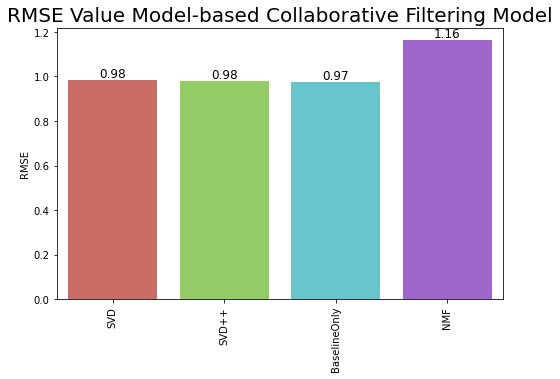

In [43]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','SVD++','BaselineOnly','NMF']
rmse_y = [svd_rmse,svdpp_rmse,blo_rmse,nmf_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='hls')
plt.title('RMSE Value Model-based Collaborative Filtering Model',fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

### __Cross-Validation__


svd = SVD()
# Run 5-fold cross-validation and print results
svd_cv = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

In [44]:
svdpp = SVDpp()
# Run 5-fold cross-validation and print results
svdpp_cv = cross_validate(svdpp, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9727  0.9743  0.9796  0.9788  0.9714  0.9753  0.0033  
Fit time          10.05   14.95   15.30   8.92    8.90    11.62   2.89    
Test time         0.26    0.44    0.28    0.23    0.32    0.31    0.07    


In [ ]:
bsl_options = {'method':'sgd', 'n_epochs':40}
blo = BaselineOnly(bsl_options=bsl_options)

# Run 5-fold cross-validation and print results
blo_cv = cross_validate(blo, data, measures=['RMSE'], cv=5, verbose=True)

#==========
# 'SGD' method performs better than 'ALS'
# Epoch 40 has the lowest mean RMSE (based on 30, 40, 50)

### __Hyperparameter Tuning with GridSearchCV__

Hyper-parameter tuning is choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a model argument whose value is set before the learning process begins. We have done Hyperparameter Tuning because it is the key in machine learning.

We have Hypertune SVD algorithm as it is the better performing algorithm compared to the others done above.


param_grid = {'n_epochs':[30,40,50], 
              'n_factors':[200,300,400], 
              'init_std_dev':[0.001, 0.005, 0.05, 0.1], 
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1, joblib_verbose=10)
grid_SVD.fit(data)
print('Best Score is: ')
print(grid_SVD.best_score['rmse'])
print('Best Parameters are: ')
print(grid_SVD.best_params['rmse'])

#### __Optimised SVD model__

In [ ]:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

### __Model based collaborative filtering on the full dataset (SVD)__

In [ ]:
# Train model on whole dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test_df.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
results.to_csv("Team_AE3_submission.csv", index=False)

In [ ]:
results.to_csv("Team_10.csv", index=False)

In [ ]:
#Save the model as pickle file
pickle.dump(svd, open('SVD_Opt.pkl','wb'))


Dealing with a large dataset has afforded us the opportunity to gather insights that could be used to better understand our User's behavior and allowed us to dig deeper in understanding how different features can be used to maximize consumer experience, with the aid of algorithms such as Content-Based and Collaborative-Filtering we were able to segregate groups with similar traits.

***Content_based_filtering***
We were able to use a mathematical approach that capitalizes on the similarity features of a user based on their historical preference to make recommendation of movies that they are most likely to be interested in watching and this can be used to drive traffic as well as monitor traffic of the app.

***Collaborative Filtering***
After carefully training and cross-validating a number of algorithms using features that our users interaction with the features such as ratings we observed that SVD which uses the probability that a user is mostly to take interest a certain product/services if they have interacted with that product/service such as rating a similar product previously, we noticed that SVD did a better job at assigning probabilities of recommend an accurate movie to a certain user using the users rating information.